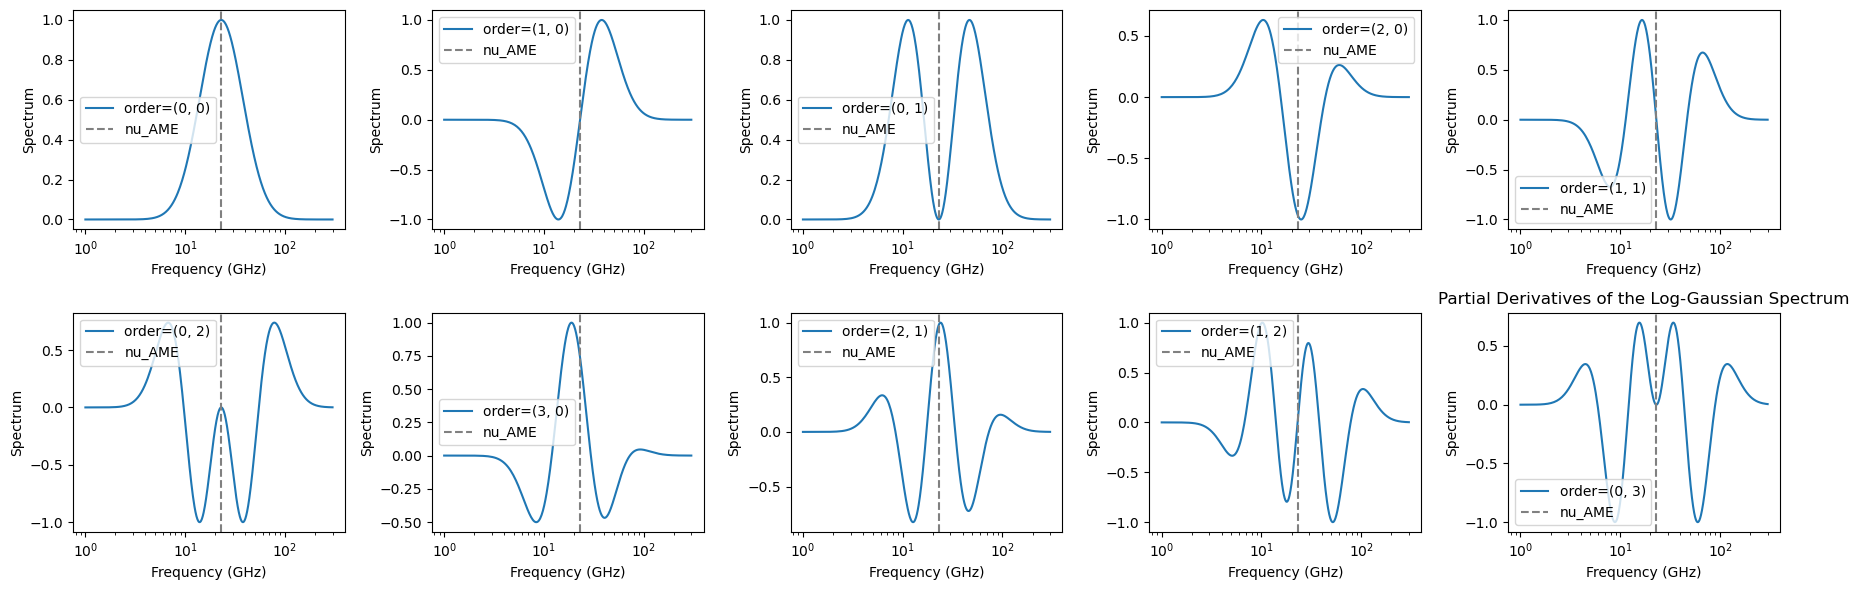

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from collections import Counter

# ----------------------------------------------------------------------------------
# 1. Build the symbolic expression exactly once
# ----------------------------------------------------------------------------------
nu, A_AME, nu_AME, W_AME = sp.symbols('nu A_AME nu_AME W_AME')
S_sym = A_AME * sp.exp(-0.5 * ((sp.log(nu) - sp.log(nu_AME)) / W_AME) ** 2)

# ----------------------------------------------------------------------------------
# 2. Factory for a *numeric* derivative of any order
# ----------------------------------------------------------------------------------
def make_log_gauss_deriv(order_A=0, order_nuAME=0, order_W=0):
    """Return a fast NumPy function for the requested partial derivative order."""
    expr = S_sym
    if order_A:
        expr = sp.diff(expr, A_AME, order_A)
    if order_nuAME:
        expr = sp.diff(expr, nu_AME, order_nuAME)
    if order_W:
        expr = sp.diff(expr, W_AME, order_W)

    # print(f"Symbolic expression for order_A={order_A}, "
    #       f"order_nuAME={order_nuAME}, order_W={order_W}:\n{expr}\n")

    # Turn the symbolic expression into a NumPy‑aware function
    # IMPORTANT: argument order must be exactly as symbols tuple!
    f_num = sp.lambdify((nu, A_AME, nu_AME, W_AME), expr, modules="numpy")
    return f_num

# ----------------------------------------------------------------------------------
# 3. Utility: generate all multi-indices α in ℕ^n with total degree ≤ d
# ----------------------------------------------------------------------------------
def generate_multi_indices(n_vars, max_degree):
    indices = []
    for deg in range(max_degree + 1):
        for c in combinations_with_replacement(range(n_vars), deg):
            counter = Counter(c)
            alpha = [counter[i] for i in range(n_vars)]
            indices.append(tuple(alpha))
    return indices

# ----------------------------------------------------------------------------------
# 4. Plot function to show requested partial derivatives
# ----------------------------------------------------------------------------------
def plot_log_gauss_derivs(nu_arr, A_AME, nu_AME, W_AME, order_indices_list):
    """
    Plot requested partial derivatives of the log-Gaussian spectrum.

    Parameters:
    - nu_arr: array of frequency values (nu)
    - A_AME, nu_AME, W_AME: numeric parameter values to evaluate derivatives at
    - order_indices_list: list of tuples with derivative orders (dNuAME, dW)
    """
    fig, ax = plt.subplots(2, (len(order_indices_list) + 1) // 2, figsize=(18, 6))

    vals_list = []
    ax = ax.flatten()  # Flatten the axes array for easier indexing

    for i, order_indices in enumerate(order_indices_list):

        assert len(order_indices) == 2, "Order_indices must have length 2. (No A derivative)"

        deri_func = make_log_gauss_deriv(order_A=0,
                                         order_nuAME=order_indices[0],
                                         order_W=order_indices[1])

        # IMPORTANT: pass arguments positionally in exactly the order given to lambdify!
        vals = deri_func(nu_arr, A_AME, nu_AME, W_AME)
        # Normalize the values for better visibility
        vals /= np.max(np.abs(vals))  # Normalize to max absolute value for visibility
        vals_list.append(vals)
        ax[i].plot(nu_arr, vals, label=f"order={order_indices}")

        # Plot a vertical line at nu_AME for reference
        ax[i].axvline(nu_AME, color='gray', linestyle='--', label='nu_AME')
        ax[i].set_xlabel("Frequency (GHz)")
        ax[i].set_xscale("log")
        ax[i].set_ylabel("Spectrum")
        ax[i].legend()
    plt.title("Partial Derivatives of the Log-Gaussian Spectrum")

    plt.tight_layout()
    plt.show()
    return vals_list

# ----------------------------------------------------------------------------------
# 5. Example usage
# ----------------------------------------------------------------------------------

# Generate all multi-indices for 2 variables (nu_AME, W_AME) up to degree 2
index_list = generate_multi_indices(2, 3)  # tuples of length 2 (dNuAME, dW)

# Frequency array
freq_arr = np.linspace(1, 300, 2048)  # in GHz

# Parameter values to evaluate at
A_AME_val = 1.0
nu_AME_val = 23.0
W_AME_val = 0.5

deri_list = plot_log_gauss_derivs(freq_arr, A_AME_val, nu_AME_val, W_AME_val, index_list)


In [16]:
# ----------------------------------------------------------------------
# 1. Symbolic source-function, as before
# ----------------------------------------------------------------------
nu, A_AME, nu_AME, W_AME = sp.symbols('nu A_AME nu_AME W_AME')
S_sym = A_AME * sp.exp(-0.5 * ((sp.log(nu) - sp.log(nu_AME)) / W_AME) ** 2)
S_func = sp.lambdify((A_AME, nu_AME, W_AME, nu), S_sym, modules="numpy")

# ----------------------------------------------------------------------
# 2.  Helpers for correlated log-normal sampling
# ----------------------------------------------------------------------
def mv_log_params(means, cov):
    """
    Convert desired means/covariance of a log-normal vector X
    to (mu, Sigma) of the underlying Normal Y = ln X.

    Parameters
    ----------
    means : (2,) array-like  –  E[X]
    cov   : (2,2) array-like –  Cov[X]

    Returns
    -------
    mu    : (2,) ndarray – mean of Y
    Sigma : (2,2) ndarray – covariance of Y
    """
    means  = np.asarray(means, dtype=float)
    cov    = np.asarray(cov,   dtype=float)

    Sigma = np.empty_like(cov)
    # diagonal
    for i in range(2):
        Sigma[i, i] = np.log(cov[i, i] / means[i]**2 + 1.0)
    # off-diagonal
    for i in range(2):
        for j in range(i + 1, 2):
            Sigma[i, j] = Sigma[j, i] = np.log(cov[i, j] / (means[i] * means[j]) + 1.0)

    mu = np.log(means) - 0.5 * np.diag(Sigma)
    return mu, Sigma


def sample_lognormal(means, cov, n_samples=100_000):
    """
    Draw correlated log-normal samples with given <X> and Cov[X].

    Returns
    -------
    samples : (n_samples, 2) ndarray
    """
    mu, Sigma = mv_log_params(means, cov)
    y = np.random.multivariate_normal(mu, Sigma, size=n_samples)
    return np.exp(y)                      # shape (n_samples, 2)

# ----------------------------------------------------------------------
# 3.  Monte-Carlo integral
# ----------------------------------------------------------------------
def monte_carlo_integral(nu_vals, means, cov, n_samples=100_000):
    """
    Estimate  ⟨S(ν)⟩  under the prior defined by (means, cov).

    Parameters
    ----------
    nu_vals  : array-like – frequencies at which to evaluate ⟨S⟩
    means    : (3,)      – mean of (A_AME, nu_AME, W_AME)
    cov      : (3,3)     – covariance matrix of those parameters
    n_samples: int       – Monte-Carlo sample size
    """
    # Draw correlated samples from the prior
    nuA_vals, W_vals = sample_lognormal(means, cov, n_samples).T

    A_vals = np.ones_like(nuA_vals)  # A_AME is fixed at 1.0

    # Monte-Carlo expectation of S(ν)
    results = []
    for nu_val in nu_vals:
        S_vals  = S_func(A_vals, nuA_vals, W_vals, nu_val)
        results.append(np.mean(S_vals))

    return np.asarray(results)

import numpy as np

# ----------------------------------------------------------------------
#  Helper: random SPD correlation matrix via "Gram → correlation"
# ----------------------------------------------------------------------
def _random_correlation():
    """
    Draw a random 2×2 correlation matrix that is guaranteed SPD.

    Returns
    -------
    R : (2,2) ndarray – correlation matrix with ones on the diagonal
    """
    A = np.random.randn(2, 2)            # any rectangular Gaussian matrix
    G = A @ A.T                          # Gram matrix => SPD
    d = np.sqrt(np.diag(G))
    return (G / d[:, None]) / d[None, :] # normalise to unit diagonal


# ----------------------------------------------------------------------
#  Public API
# ----------------------------------------------------------------------
def random_covariance_samples(means, n_samples=1,
                              std_min_factor=0.01, std_max_factor=1,
                              log_space=True, seed=None):
    """
    Generate `n_samples` covariance matrices consistent with the
    user-specified σ-range.

    Parameters
    ----------
    means           : (2,) array-like – component means (μ_A, μ_νA, μ_W)
    n_samples       : int             – number of matrices to return
    std_min_factor  : float           – lower bound σ/μ  (default 0.01)
    std_max_factor  : float           – upper bound σ/μ  (default 2.0)
    log_space       : bool            – sample σ/μ uniformly in log10-space
    seed            : int or None     – random seed for reproducibility

    Returns
    -------
    covariances : (n_samples, 2, 2) ndarray
    """
    rng = np.random.default_rng(seed)
    means = np.asarray(means, dtype=float)
    covs  = np.empty((n_samples, 2, 2))

    # --- draw n_samples independent covariance matrices ---
    for k in range(n_samples):
        # 1. Pick the three standard deviations
        if log_space:
            log_min = np.log10(std_min_factor)
            log_max = np.log10(std_max_factor)
            log_sigma_over_mu = rng.uniform(log_min, log_max, size=2)
            sigmas = means * 10**log_sigma_over_mu
        else:
            sigmas = means * rng.uniform(std_min_factor, std_max_factor, size=2)

        # 2. Draw a random SPD correlation matrix
        R = _random_correlation()

        # 3. Build the covariance:  Σ = D R D
        D  = np.diag(sigmas)
        covs[k] = D @ R @ D

    return covs if n_samples > 1 else covs[0]



In [17]:
means = np.array([23.0, 0.8])
C_list     = random_covariance_samples(means, n_samples=10, seed=42)
for i, cov in enumerate(C_list):
    print(f"Covariance matrix {i}:\n{cov}\n")

Covariance matrix 0:
[[6.59598814e+01 4.42083590e-01]
 [4.42083590e-01 3.64496811e-03]]

Covariance matrix 1:
[[ 1.43829295e+02 -4.37224604e-01]
 [-4.37224604e-01  3.94141432e-02]]

Covariance matrix 2:
[[ 0.1259404  -0.02104412]
 [-0.02104412  0.51129245]]

Covariance matrix 3:
[[58.61577075  1.1664537 ]
 [ 1.1664537   0.08921486]]

Covariance matrix 4:
[[0.17215126 0.01730695]
 [0.01730695 0.00405251]]

Covariance matrix 5:
[[ 1.60933986 -0.02632794]
 [-0.02632794  0.32601676]]

Covariance matrix 6:
[[19.90289044 -1.57140871]
 [-1.57140871  0.1250911 ]]

Covariance matrix 7:
[[ 3.14132208e+00 -1.82768996e-02]
 [-1.82768996e-02  5.18961167e-04]]

Covariance matrix 8:
[[ 8.74570492e+00 -3.05518971e-02]
 [-3.05518971e-02  1.15199077e-04]]

Covariance matrix 9:
[[ 1.08138505e+02 -7.05032147e-01]
 [-7.05032147e-01  2.15197673e-02]]



/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_97932/606229952.py:51: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y = np.random.multivariate_normal(mu, Sigma, size=n_samples)
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_97932/724976076.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


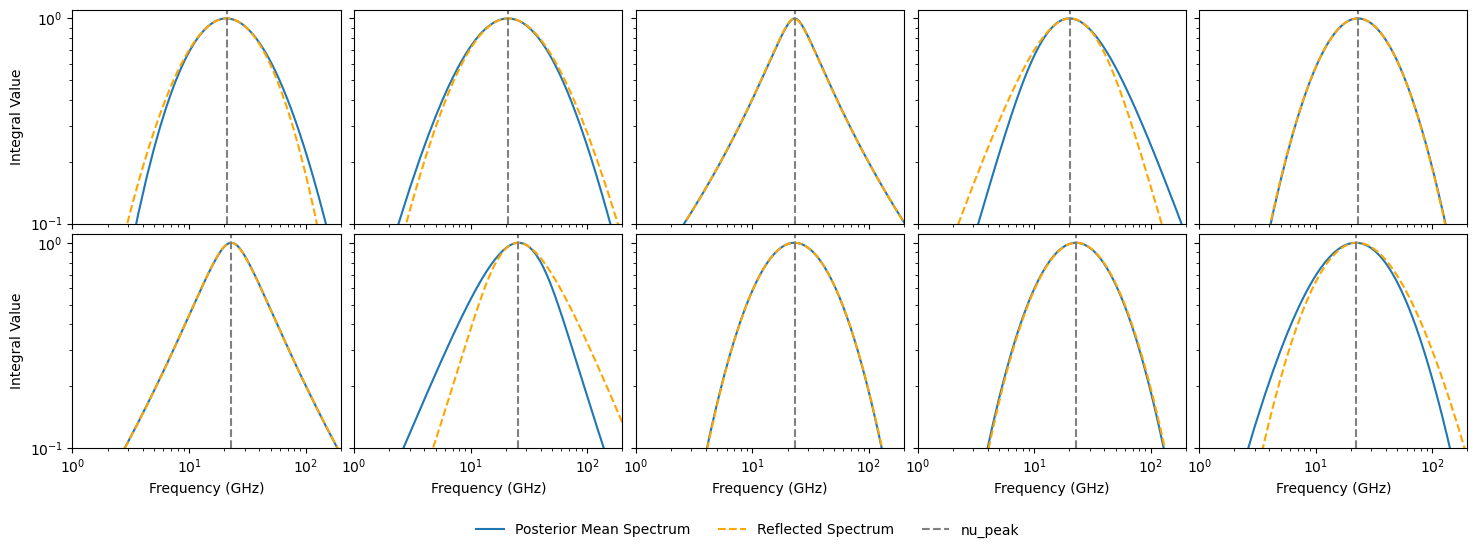

In [18]:
fig, ax = plt.subplots(2, (len(C_list) + 1) // 2, figsize=(18, 6), sharey=True, sharex=True, 
                       gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

ax = ax.flatten()
lines_labels = []

for i, cov in enumerate(C_list):
    vals = monte_carlo_integral(nu_vals, means, cov)
    vals = vals / np.max(np.abs(vals))

    idx_peak = np.argmax(vals)
    nu_c = nu_vals[idx_peak]
    nu_vals_reflected = np.exp(2*np.log(nu_c) - np.log(nu_vals))

    l1, = ax[i].plot(nu_vals, vals, label='Posterior Mean Spectrum')
    l2, = ax[i].plot(nu_vals_reflected, vals, linestyle='--', color='orange', label='Reflected Spectrum')
    l3 = ax[i].axvline(nu_c, color='gray', linestyle='--', label='nu_peak')

    if i == 0:  # only need one set of handles
        lines_labels = [l1, l2, l3]

    ax[i].set_xlim([1, 200])
    ax[i].set_ylim([0.1, 1.1])
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('Frequency (GHz)')
    if i == 0 or i == len(C_list) // 2:
        ax[i].set_ylabel('Integral Value')

# Add a single legend to the figure (outside the axes grid)
fig.legend(lines_labels, [line.get_label() for line in lines_labels],
           loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.02))

fig.tight_layout()
plt.subplots_adjust(bottom=0.15)  # leave space for global legend
plt.savefig('logN_ensemble_spectra.png', dpi=300, bbox_inches='tight')


In [19]:
Y_samples = sample_lognormal(means, cov, n_samples=100_000)

# Check if the means and covariance of the samples match the input parameters
print("Desired means:", means)
print("Sample means:", np.mean(Y_samples, axis=0))

print("Desired covariance:\n", cov)
print("Sample covariance:\n", np.cov(Y_samples, rowvar=False))

Desired means: [23.   0.8]
Sample means: [23.01001518  0.79921547]
Desired covariance:
 [[ 1.08138505e+02 -7.05032147e-01]
 [-7.05032147e-01  2.15197673e-02]]
Sample covariance:
 [[ 1.08386277e+02 -6.96008314e-01]
 [-6.96008314e-01  2.12812246e-02]]
